In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers=classifiers
        self.named_classifiers={key: value for key, value in _name_estimators(classifiers)}
        self.vote=vote
        self.weights=weights
    
    def fit(self, X, y):
        if self.vote not in ('probability','classlabel'):
            raise ValueError("Il voto deve essere classlabel o probabilità")
        if self.weights and len(self.weights)!=len(self.classifiers):
            raise ValueError("Numero di classificatori e di pesi deve esserr uguale")
        self.lablenc_=LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_=self.lablenc_.classes_
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf=clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self,X):
        if self.vote=='probability':
            maj_vote=np.argmax(self.predict_proba(X),axis=1)
        else: 
            predictions=np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote=np.apply_along_axis (lambda x: np.argmax(np.bincount(x,weights=self.weights)) , axis=1,arr=predictions )
        maj_vote=self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self,X):
        probas=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba=np.average(probas,axis=0,weights=self.weights)
        return avg_proba
    def get_params( self , deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out=self.named_classifiers.copy()
        for name, step in self.named_classifiers.items():
            for key, value in step.get_params(deep=True).items():
                out['%s__%s'%(name,key)]=value
        return out

Implementato, ora provo a farlo girare su Iris

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]], iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                    test_size=0.5,
                                    random_state=1,
                                    stratify=y)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1=LogisticRegression(penalty='l2',
        C=0.001,
        solver='lbfgs',
        random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,
        criterion='entropy',
        random_state=0)
clf3=KNeighborsClassifier(n_neighbors=1,
        p=2,
        metric='minkowski')
pipe1=Pipeline([['sc' , StandardScaler()], ['clf', clf1]])
pipe3=Pipeline([['sc' , StandardScaler()], ['clf', clf3]])
clf_labels=['Logistic regression', 'Decision tree', 'KNN']
for clf, label in zip([pipe1,clf2,pipe3],clf_labels ):
    scores = cross_val_score(estimator=clf,
                X=X_train, 
                y=y_train, 
                cv=10, 
                scoring='roc_auc')
    print ("ROC AUC: %0.2f (+/− %0.2f) [%s]"% (scores.mean(),scores.std(),label))



ROC AUC: 0.92 (+/− 0.15) [Logistic regression]
ROC AUC: 0.87 (+/− 0.18) [Decision tree]
ROC AUC: 0.85 (+/− 0.13) [KNN]


In [6]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores=cross_val_score(estimator=clf,
                X=X_train,
                y=y_train,
                cv=10,
                scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f)[%s]" %(scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15)[Logistic regression]
ROC AUC: 0.87 (+/- 0.18)[Decision tree]
ROC AUC: 0.85 (+/- 0.13)[KNN]
ROC AUC: 0.98 (+/- 0.05)[Majority Voting]


Roc Curve

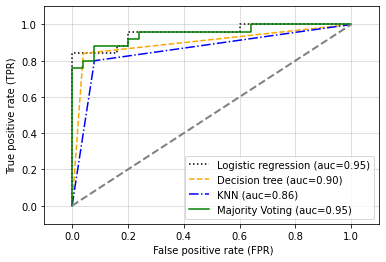

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black','orange','blue','green']
linestyles=[':','--','-.','-']
for clf,label,clr,ls in zip (all_clf,clf_labels,colors,linestyles):
    y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc=auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls, label='%s (auc=%0.2f)'% (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle ='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel(' False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()
